In [119]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

train_filename = "train.csv"
test_filename = "test.csv"
gender_submission = "gender_submission.csv"

def load_data(filename):
    train = pd.read_csv(filename)
    return train

data = load_data(train_filename)


from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=50)


data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


       PassengerId    Survived      Pclass         Age       SibSp  \
count   712.000000  712.000000  712.000000  566.000000  712.000000   
mean    440.278090    0.370787    2.286517   30.236608    0.525281   
std     257.106262    0.483355    0.848222   14.469209    1.122300   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     215.750000    0.000000    1.000000   21.000000    0.000000   
50%     432.500000    0.000000    3.000000   29.000000    0.000000   
75%     661.250000    1.000000    3.000000   39.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  712.000000  712.000000  
mean     0.359551   33.038108  
std      0.772192   49.554624  
min      0.000000    0.000000  
25%      0.000000    7.925000  
50%      0.000000   15.047900  
75%      0.000000   31.275000  
max      5.000000  512.329200  
567    female
648      male
790      male
618    female
77       male
11     fema

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f361b526438>,
      dtype=object)

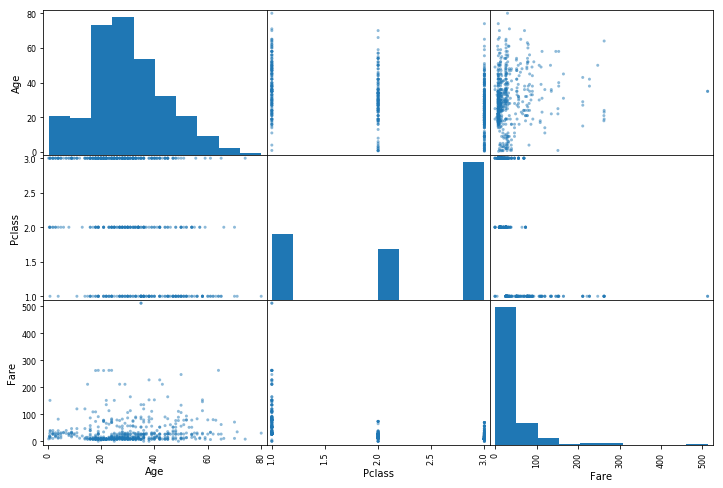

In [120]:
train.dropna(subset=["Cabin", "Ticket"])
print(train.describe())

X = train.values[:,2:]
Y = train.values[:,1]

sex_cat = train["Sex"]
sex_cat_enc, sex = sex_cat.factorize()
print(sex_cat.head(10))
print(sex_cat_enc[0:10])
print(sex)



pclass = train.values[:,2]

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
pclass_1hot = encoder.fit_transform(pclass.reshape(-1,1))
pclass_1hot.toarray()


from pandas.plotting import scatter_matrix

attributes = ["Age", "Pclass", "Fare"]
scatter_matrix(train[attributes], figsize=(12,8))

In [121]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataSel(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values    

    
Embarked_idx = 11
attribute_name = "Embarked"
class CleanEmbarked(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.rep_values = 'S'
        
    def fit(self, X, y=None):
        idx = (X[attribute_name].isnull())
        
        index = np.where(idx == False)
        unique, counts = np.unique(X[attribute_name].values[index], return_counts=True)
        
        max_id = np.argmax(counts) 
        self.rep_values = unique[max_id]
        return self
    
    def transform(self, X):
        X[attribute_name].replace(np.nan, self.rep_values, inplace=True)
        return X


In [126]:
attributes_num = ["Age", "SibSp", "Parch", "Fare"]

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer

num_pipeline = Pipeline([
    ('selector', DataSel(attributes_num)),
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

train_prep_num = num_pipeline.fit_transform(train)
train_prep_num

/usr/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[-0.07621033, -0.46836875,  4.71775182, -0.24158225],
       [-0.07621033, -0.46836875, -0.4659508 , -0.51470526],
       [-0.07621033, -0.46836875, -0.4659508 , -0.51066648],
       ...,
       [-0.07621033,  0.42328513, -0.4659508 , -0.17948589],
       [-1.62672331,  3.98990065,  2.12590051,  0.27992619],
       [-0.92899247, -0.46836875, -0.4659508 , -0.50974159]])

In [123]:
attributs_cat = ["Pclass", "Sex", "Embarked"]

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import CategoricalEncoder

train_cat = train[attributs_cat]

cat_encoder = CategoricalEncoder(encoding="onehot-dense")

attribute_name = "Embarked"
idx = (train[attribute_name].isnull())
      
index = np.where(idx == False)

unique, counts = np.unique(train[attribute_name].values[index], return_counts=True)
        
max_id = np.argmax(counts) 

clean_em = CleanEmbarked()
train_cat = clean_em.fit_transform(train_cat)

cat_pipeline = Pipeline([
    ('Embarked_cleaner', CleanEmbarked()),
    ('selector', DataSel(attributs_cat)),
    ('cat_encoder', CategoricalEncoder()),
])

train_prep_cat = cat_pipeline.fit_transform(train)
train_prep_cat

/usr/lib/python3.6/site-packages/pandas/core/generic.py:5886: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


<712x8 sparse matrix of type '<class 'numpy.float64'>'
	with 2136 stored elements in Compressed Sparse Row format>

In [124]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

full_pipe = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [132]:
train_prep = full_pipe.fit_transform(train)
Y_train = train["Survived"].values

train_prep.shape

/usr/lib/python3.6/site-packages/pandas/core/generic.py:5886: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


(712, 12)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

n_estim = np.arange(30,60,5)
n_feat = np.arange(1,12,1)

param_grid = [
    {'bootstrap': [False,True], 'n_estimators':n_estim, 'max_features': n_feat},
]

forest = RandomForestClassifier()

grid_search = GridSearchCV(forest, param_grid, cv=5,
                          scoring='accuracy', n_jobs=4)

grid_search.fit(train_prep, Y_train)

print(grid_search.best_params_)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

In [150]:
from sklearn.metrics import precision_score, recall_score


Y_train_pred = grid_search.predict(train_prep)

X_test_prep = full_pipe.transform(test)
Y_test = test["Survived"].values
Y_test_pred = grid_search.predict(X_test_prep)

train_correct = sum(Y_train_pred == Y_train)
test_correct = sum(Y_test_pred == Y_test)

pre_train = precision_score(Y_train, Y_train_pred, average='weighted')
rec_train = recall_score(Y_train, Y_train_pred, average='weighted')
pre_test = precision_score(Y_test, Y_test_pred, average='weighted')
rec_test = recall_score(Y_test, Y_test_pred, average='weighted')



print("Correct train :", train_correct, "\t Incorrect train :", len(Y_train)- train_correct)
print("Correct test :", test_correct, "\t Incorrect test :", len(Y_test)- test_correct)
print("Precision Train :", pre_train, "Recall Train :", rec_train)
print("Precision Test :", pre_test, "Recall Test :", rec_test)


from sklearn.metrics import confusion_matrix

print(confusion_matrix(Y_train, Y_train_pred))



Correct train : 694 	 Incorrect train : 18
Correct test : 144 	 Incorrect test : 35
Precision Train : 0.9747045685745099 Recall Train : 0.9747191011235955
Precision Test : 0.8092279678197613 Recall Test : 0.8044692737430168
[[441   7]
 [ 11 253]]


/usr/lib/python3.6/site-packages/pandas/core/generic.py:5886: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
